In [ ]:
from data.cifrar100 import *


train_loader, val_loader, test_loader = get_cifar100_dataloaders(
    batch_size=64,
    data_dir="./data/cifar100",
    num_workers=2,
    val_split=0.1)

100%|██████████| 169M/169M [00:18<00:00, 9.05MB/s]


In [ ]:

CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

images, labels = next(iter(train_loader))

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Images dtype: {images.dtype}, Labels dtype: {labels.dtype}")

Images shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])
Images dtype: torch.float32, Labels dtype: torch.int64


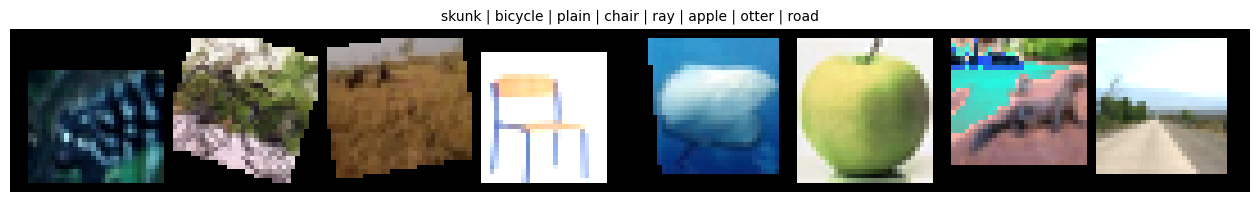

In [ ]:
from data.data_utils import *


cifar100_train = datasets.CIFAR100(
    root="./data/cifar100",
    train=True,
    download=False)
class_names = cifar100_train.classes

show_batch(images, labels, class_names=class_names, n=8)

---

# Model

In [ ]:
from model.window_partition import *

B, H, W, C = 2, 15, 17, 96
ws = 7
ss = ws // 2

x = torch.randn(B, H, W, C)

# SW-MSA prep
win, meta = prepare_windows(x, window_size=ws, shift_size=ss)
mask = meta["attn_mask"]
print(win.shape)      # [B*nW, ws*ws, C]
print(mask.shape)     # [nW, ws*ws, ws*ws]  (si ss>0)

# "Simulamos" salida de atención: misma forma
y = win.clone()

# Reverse
x_rec = restore_from_windows(y, meta, C=C)
print(x_rec.shape)    # [B, H, W, C]

torch.Size([18, 49, 96])
torch.Size([9, 49, 49])
torch.Size([2, 15, 17, 96])


In [ ]:
from model.swin_attention import *

torch.manual_seed(0)

B, H, W, C = 2, 15, 17, 96
ws = 7
ss = ws // 2
num_heads = 3

x = torch.randn(B, H, W, C)

attn = WindowAttention(dim=C, window_size=ws, num_heads=num_heads,
                       attn_dropout=0.0, proj_dropout=0.0, use_rel_pos_bias=True)

win_w, meta_w = prepare_windows(x, window_size=ws, shift_size=0)
y_w = attn(win_w, mask=meta_w["attn_mask"])

print("W-MSA windows in :", win_w.shape)     # [B*nW, ws*ws, C]
print("W-MSA windows out:", y_w.shape)       # misma shape
assert y_w.shape == win_w.shape


win_sw, meta_sw = prepare_windows(x, window_size=ws, shift_size=ss)
mask = meta_sw["attn_mask"]
y_sw = attn(win_sw, mask=mask)

print("SW-MSA windows in :", win_sw.shape)
print("SW-MSA mask       :", None if mask is None else mask.shape)  # [nW, N, N]
print("SW-MSA windows out:", y_sw.shape)
assert y_sw.shape == win_sw.shape
assert mask is not None and mask.ndim == 3


m_min = float(mask.min())
m_max = float(mask.max())
print("Mask min/max:", m_min, m_max)
assert m_max == 0.0, "La máscara Swin debe tener 0 en posiciones permitidas."
assert m_min < -1e20, "La máscara debería tener valores muy negativos (-inf aprox)."


win_sw.requires_grad_(True)
y = attn(win_sw, mask=mask)
loss = y.mean()
loss.backward()
g = win_sw.grad
print("Grad ok?  finite:", torch.isfinite(g).all().item(), " mean|g|:", g.abs().mean().item())
assert torch.isfinite(g).all(), "Gradientes no finitos."

print("Sanity check WindowAttention OK")

W-MSA windows in : torch.Size([18, 49, 96])
W-MSA windows out: torch.Size([18, 49, 96])
SW-MSA windows in : torch.Size([18, 49, 96])
SW-MSA mask       : torch.Size([9, 49, 49])
SW-MSA windows out: torch.Size([18, 49, 96])
Mask min/max: -3.4028234663852886e+38 -0.0
Grad ok?  finite: True  mean|g|: 3.2663756428519264e-06
Sanity check WindowAttention OK


In [ ]:
from model.swin_block import *

torch.manual_seed(0)
x = torch.randn(2, 15, 17, 96)

blk = SwinTransformerBlock(dim=96, num_heads=3, window_size=7, shift_size=3,
                           attn_dropout=0.0, proj_dropout=0.0, mlp_dropout=0.0, drop_path=0.0)

y = blk(x)
print(x.shape, y.shape)
assert y.shape == x.shape
print("SwinTransformerBlock OK")

torch.Size([2, 15, 17, 96]) torch.Size([2, 15, 17, 96])
SwinTransformerBlock OK


In [ ]:
from model.patch_merging import *

torch.manual_seed(0)
x = torch.randn(2, 15, 17, 96)

pm = PatchMerging(dim=96)
y = pm(x)

print("in :", x.shape)
print("out:", y.shape)

in : torch.Size([2, 15, 17, 96])
out: torch.Size([2, 8, 9, 192])


In [ ]:
from model.swin_vision_transformer import *

torch.manual_seed(0)

model = SwinTransformer(
    img_size=32,
    patch_size=4,
    in_chans=3,
    num_classes=100,
    embed_dim=96,
    depths=(2, 2, 6, 2),
    num_heads=(3, 6, 12, 24),
    window_size=4,
    drop_path_rate=0.1,)

x = torch.randn(2, 3, 32, 32)
y = model(x)
print(y.shape)  # [2, Clases]

torch.Size([2, 100])


---

In [ ]:
from training.train_vit import *

model = SwinTransformer(
    img_size=32,
    patch_size=2,
    in_chans=3,
    num_classes=100,
    embed_dim=96,
    depths=(2, 2, 6, 2),
    num_heads=(3, 6, 12, 24),
    window_size=4,
    drop_path_rate=0.2)

history = train_swinvit(
    model=model, train_loader=train_loader, val_loader=val_loader,
    epochs=20, device="cuda",
    lr=5e-4, weight_decay=0.05,
    autocast_dtype="bf16", use_amp=True,
    grad_clip_norm=1.0,
    save_path="best_swin_cifar100.pt")


=== Epoch 1/20 ===
[train step 100/704] loss 4.6653 | top1 1.91% | top3 5.88% | top5 8.91% | 460.8 img/s
[train step 200/704] loss 4.5792 | top1 2.59% | top3 7.16% | top5 11.18% | 486.8 img/s
[train step 300/704] loss 4.5329 | top1 2.99% | top3 7.85% | top5 12.52% | 495.2 img/s
[train step 400/704] loss 4.4949 | top1 3.41% | top3 8.70% | top5 13.68% | 499.5 img/s
[train step 500/704] loss 4.4596 | top1 3.76% | top3 9.60% | top5 14.77% | 495.7 img/s
[train step 600/704] loss 4.4315 | top1 4.05% | top3 10.34% | top5 15.74% | 498.7 img/s
[train step 700/704] loss 4.4079 | top1 4.25% | top3 10.84% | top5 16.50% | 502.2 img/s
[Train] loss 4.4071 | top1 4.26% | top3 10.85% | top5 16.51%
[Val]   loss 4.2675 | top1 6.02% | top3 14.24% | top5 20.94%
 Best saved to best_swin_cifar100.pt (val top1 6.02%)
Epoch time: 1.61 min

=== Epoch 2/20 ===
[train step 100/704] loss 4.2132 | top1 7.20% | top3 16.53% | top5 23.64% | 506.8 img/s
[train step 200/704] loss 4.2101 | top1 7.33% | top3 16.56% | top